In [41]:
import os
import time
import pprint
import argparse
import torch
import numpy as np
import pickle
import utils
import csv

from model.hidden import Hidden
from noise_layers.noiser import Noiser
from average_meter import AverageMeter
from noise_argparser import NoiseArgParser

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [42]:
data_dir='/tmp2/jimmyliu/HiDDeN_experiment/dataset_10000'
#current_run='/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-noise-256-adam 2023.05.20--02-44-07'
current_run="/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-baseline-256-adam-mse 2023.05.26--16-28-10"
batch_size=2
round=True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
options_file = os.path.join(current_run, 'options-and-config.pickle')
train_options, hidden_config, _ = utils.load_options(options_file)
train_options.train_folder = os.path.join(data_dir, 'val')
train_options.validation_folder = os.path.join(data_dir, 'train')
train_options.batch_size = batch_size
noise_config=[]

In [43]:
checkpoint, chpt_file_name = utils.load_checkpoint('/tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-baseline-256-adam-mse 2023.05.26--16-28-10/checkpoints/combined-baseline-256-adam-mse--epoch-104.pyt')
print(f'Loaded checkpoint from file {chpt_file_name}')

noiser = Noiser(noise_config,device)
model = Hidden(hidden_config, device, noiser, tb_logger=None,train_options=train_options)
utils.model_from_checkpoint(model, checkpoint)
model.encoder_decoder.eval()

Loaded checkpoint from file /tmp2/jimmyliu/HiDDeN_experiment/ss_HiDDeN/runs/combined-baseline-256-adam-mse 2023.05.26--16-28-10/checkpoints/combined-baseline-256-adam-mse--epoch-104.pyt


EncoderDecoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (3): ConvBNRelu(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel

In [44]:
_, val_data = utils.get_data_loaders(hidden_config, train_options)
file_count = len(val_data.dataset)
if file_count % train_options.batch_size == 0:
            steps_in_epoch = file_count // train_options.batch_size
else:
    steps_in_epoch = file_count // train_options.batch_size + 1

In [45]:
print(file_count)

10000


In [46]:

step = 0
losses_accu={}

ori_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        if step==0:
            ori_list_arr=decoded_messages.detach().cpu()
        else:
            ori_list_arr=torch.cat( (ori_list_arr,decoded_messages.detach().cpu()),0 )



        step += 1
        '''
        if step >=2:
            break
        '''

In [47]:

if round:
    ruond_ori_list_arr=ori_list_arr.round().clip(0, 1)

miu=torch.mean(ori_list_arr, 0)
round_miu=torch.mean(ruond_ori_list_arr, 0)

In [48]:
print(miu.mean())
print(round_miu.mean())
print(miu)
print(round_miu)

tensor(0.4815)
tensor(0.4275)
tensor([0.6125, 0.3197, 0.3167, 0.6603, 0.5052, 0.4505, 0.4465, 0.7151, 0.5793,
        0.4692, 0.4381, 0.3727, 0.4873, 0.3706, 0.6493, 0.4408, 0.3981, 0.4677,
        0.4504, 0.5344, 0.6927, 0.5180, 0.4296, 0.5938, 0.4709, 0.8431, 0.3889,
        0.3563, 0.2089, 0.5773, 0.4815, 0.5769, 0.4213, 0.5802, 0.5705, 0.5844,
        0.4400, 0.3169, 0.3615, 0.3930, 0.5013, 0.4074, 0.2804, 0.5841, 0.5023,
        0.2676, 0.6780, 0.4028])
tensor([0.8516, 0.0208, 0.0228, 0.9787, 0.5445, 0.2799, 0.1259, 0.9884, 0.7796,
        0.3445, 0.1467, 0.0186, 0.4079, 0.0531, 0.9656, 0.2302, 0.0429, 0.3628,
        0.2287, 0.6869, 0.9779, 0.6257, 0.1123, 0.9605, 0.3874, 0.9979, 0.1015,
        0.0532, 0.0024, 0.7768, 0.4231, 0.9012, 0.0983, 0.9460, 0.8680, 0.8413,
        0.1659, 0.0110, 0.0984, 0.0615, 0.4936, 0.0546, 0.0103, 0.8310, 0.5592,
        0.0114, 0.9865, 0.0833])


In [49]:
ori_list_arr

tensor([[0.6130, 0.4598, 0.1670,  ..., 0.3596, 0.7207, 0.3966],
        [0.7536, 0.4022, 0.3086,  ..., 0.3559, 0.6889, 0.4750],
        [0.7496, 0.1116, 0.2151,  ..., 0.0615, 0.6291, 0.5394],
        ...,
        [0.6388, 0.3934, 0.3473,  ..., 0.3057, 0.7314, 0.3962],
        [0.5463, 0.3473, 0.3162,  ..., 0.2873, 0.6211, 0.4327],
        [0.8155, 0.1544, 0.2214,  ..., 0.0061, 0.8271, 0.4312]])

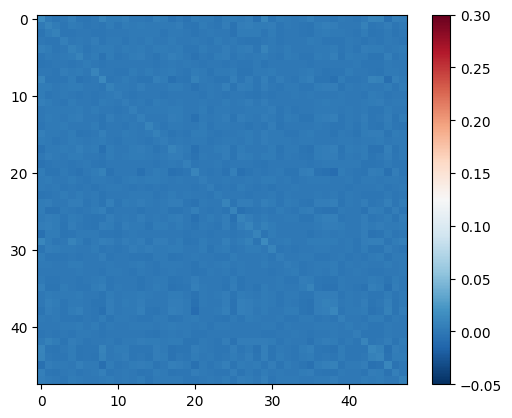

In [50]:
conv_matrix=torch.cov(ori_list_arr.T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()



In [51]:

print(torch.sum(torch.diag(conv_matrix)))

tensor(0.3301)


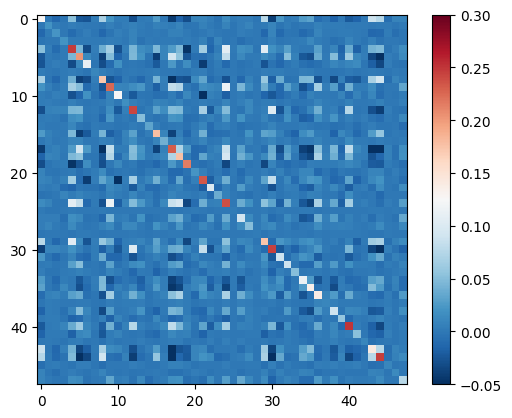

In [52]:
round_conv_matrix=torch.cov(ruond_ori_list_arr.T)

#plt.matshow(conv_matrix, cmap=plt.cm.Blues)
plt.imshow(round_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()

In [53]:
print(round_conv_matrix.T == round_conv_matrix)

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])


In [54]:
conv_matrix=(conv_matrix.T+conv_matrix)/2
print(torch.all(conv_matrix.T == conv_matrix))
ori_diag=torch.diag(conv_matrix)

tensor(True)


In [55]:
L, V = torch.linalg.eig(conv_matrix)
#L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))
#b=-(L_matrix@V.T).to(torch.float)@(
# 
# -0.5)
b=-(L_matrix@V.T).to(torch.float)@miu
w=(L_matrix@V.T).to(torch.float)
b=(b+1.)/2.
w=w/2.
eig_whitening_layer=nn.Linear(48,48)
eig_whitening_layer.weight=nn.Parameter(w)
eig_whitening_layer.bias=nn.Parameter(b)
eig_whitening_layer=eig_whitening_layer.to(device)
eig_whitening_layer.eval()

Linear(in_features=48, out_features=48, bias=True)

In [56]:
#L, V = torch.linalg.eig(conv_matrix)
L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))

#b=-(L_matrix@V.T).to(torch.float)@(miu-0.5)
b=-(L_matrix@V.T)@miu
w=(L_matrix@V.T)
b=(b+1.)/2.
w=w/2.
eigh_whitening_layer=nn.Linear(48,48)
eigh_whitening_layer.weight=nn.Parameter(w)
eigh_whitening_layer.bias=nn.Parameter(b)
eigh_whitening_layer=eigh_whitening_layer.to(device)
eigh_whitening_layer.eval()

Linear(in_features=48, out_features=48, bias=True)

In [57]:
#eig_whitening_layer=torch.load('/tmp2/jimmyliu/whiten.pt')
#eig_whitening_layer.eval()
#eig_whitening_layer=eig_whitening_layer.to(device)

In [58]:

step = 0
losses_accu={}

eig_list_arr=[]

eigh_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        eig_decoded_messages=eig_whitening_layer(decoded_messages)
        eigh_decoded_messages=eigh_whitening_layer(decoded_messages)


        if step==0:
            eig_list_arr=eig_decoded_messages.detach().cpu()
            eigh_list_arr=eigh_decoded_messages.detach().cpu()
        else:
            eig_list_arr=torch.cat( (eig_list_arr,eig_decoded_messages.detach().cpu()),0 )
            eigh_list_arr=torch.cat( (eigh_list_arr,eigh_decoded_messages.detach().cpu()),0 )



        step += 1
       

In [59]:
print(decoded_messages)

tensor([[0.5463, 0.3473, 0.3162, 0.7173, 0.4792, 0.5316, 0.4636, 0.8168, 0.4782,
         0.5222, 0.3870, 0.3380, 0.4662, 0.4225, 0.6746, 0.3828, 0.4094, 0.5898,
         0.5034, 0.5129, 0.5668, 0.5745, 0.5474, 0.5450, 0.4927, 0.8458, 0.4244,
         0.3199, 0.2366, 0.5780, 0.4036, 0.5490, 0.3867, 0.6318, 0.4896, 0.5946,
         0.4678, 0.3253, 0.4762, 0.2860, 0.5191, 0.4330, 0.2349, 0.5037, 0.4633,
         0.2873, 0.6211, 0.4327],
        [0.8155, 0.1544, 0.2214, 0.7276, 0.5997, 0.4391, 0.5120, 0.8804, 0.7513,
         0.3936, 0.4996, 0.3864, 0.5124, 0.2265, 0.5192, 0.5425, 0.3771, 0.4216,
         0.3013, 0.3558, 0.9209, 0.3619, 0.4173, 0.5997, 0.3472, 0.8318, 0.2633,
         0.2870, 0.1990, 0.7080, 0.4333, 0.6226, 0.2953, 0.5325, 0.6201, 0.7510,
         0.3529, 0.0463, 0.1942, 0.4145, 0.4525, 0.3533, 0.2609, 0.7496, 0.4904,
         0.0061, 0.8271, 0.4312]], device='cuda:0')


In [60]:
print(eig_decoded_messages)

tensor([[ 0.9183,  0.3916,  0.5027,  0.0381,  0.5360,  0.1794,  0.8584,  0.9070,
          0.9325,  0.9061,  0.8398, -0.1810,  0.6640,  0.0603,  1.2009,  0.7655,
          0.2554,  1.2328,  0.1478,  0.2495,  0.4003,  0.1978,  0.9142,  0.2217,
          0.7217,  0.1237, -0.3615,  0.5545,  0.2013,  0.5999,  0.3645,  0.9981,
          0.2115, -0.5523,  1.0120,  0.6816,  0.9543,  1.4635,  0.1484,  0.1930,
         -0.0620, -0.0637,  0.3399,  0.3688,  0.9092, -0.6053,  1.6585,  0.8839],
        [-0.6086,  0.5858,  0.8550,  0.1634,  0.6798, -0.2551,  1.8248,  0.5357,
         -0.8970,  0.5416,  0.5482,  1.6960, -0.2226,  0.5173,  0.1900,  1.4590,
          0.3474,  1.2005,  1.0485,  0.4666,  0.2465, -0.1510,  0.5000,  0.0413,
          0.1651, -0.3314,  0.3489,  0.8597,  1.0297,  0.6555,  0.2392,  0.5367,
          0.9387,  1.3441,  0.1774,  0.4331,  1.1469, -0.0362,  0.3392,  0.6188,
          0.4235,  0.9756,  0.1831,  0.0647,  0.9381,  0.2813,  0.5802, -0.1996]],
       device='cuda:0')


In [61]:
noround_eig_miu=torch.mean(eig_list_arr, 0)
noround_eigh_miu=torch.mean(eigh_list_arr, 0)

#eig_list_arr=eig_list_arr/2+0.5
#eigh_list_arr=eigh_list_arr/2+0.5
if round:
    round_eig_list_arr=eig_list_arr.round().clip(0, 1)
    round_eigh_list_arr=eigh_list_arr.round().clip(0, 1)



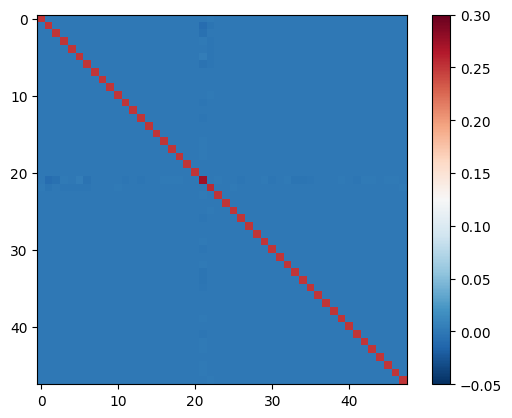

In [62]:
eig_conv_matrix=torch.cov((eig_list_arr).T)
#plt.imshow(eig_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdYlBu_r")
plt.imshow(eig_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()

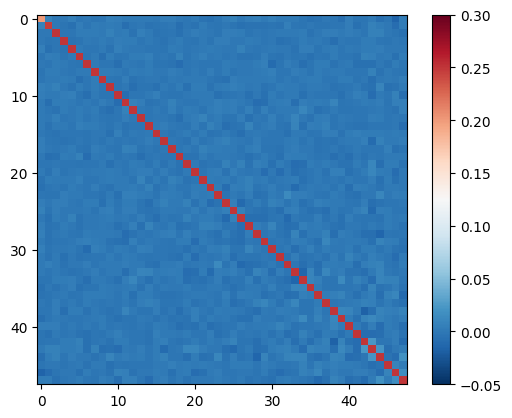

In [63]:
eigh_conv_matrix=torch.cov((round_eigh_list_arr).T)
plt.imshow(eigh_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()

In [64]:
print(torch.diag(eig_conv_matrix))
print(torch.diag(eigh_conv_matrix))
print(torch.sum(torch.diag(eig_conv_matrix)))
print(torch.sum(torch.diag(eigh_conv_matrix)))
eig_diag=torch.diag(eig_conv_matrix)
eigh_diag=torch.diag(eigh_conv_matrix)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2737, 0.2558, 0.2500, 0.2500, 0.2501, 0.2500,
        0.2500, 0.2500, 0.2501, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2499])
tensor([0.1989, 0.2463, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2499, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2499, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2499,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2499, 0.2498, 0.2500,
        0.2496, 0.2495, 0.2500, 0.2497, 0.2499, 0.2494, 0.2499, 0.2499, 0.2497,
        0.2500, 0.2496, 0.2500])
tensor(12.0297)
tensor(11.9418)


In [65]:
print(12/0.3301)

36.35262041805513


In [66]:
print(noround_eig_miu.mean())
print(noround_eigh_miu.mean())

tensor(0.4930)
tensor(0.4933)


In [67]:
L, V = torch.linalg.eig(conv_matrix)
#L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))
diag_factor=torch.diag_embed(torch.sqrt(ori_diag/eig_diag))
#b=-(L_matrix@V.T).to(torch.float)@(
# 
# -0.5)
b=-(L_matrix@V.T).to(torch.float)@miu
w=(L_matrix@V.T).to(torch.float)
b=(b+1.)/2.
w=w/2.
w=diag_factor@w
b=diag_factor@(b-0.5)+0.5
eig_whitening_layer=nn.Linear(48,48)
eig_whitening_layer.weight=nn.Parameter(w)
eig_whitening_layer.bias=nn.Parameter(b)
eig_whitening_layer=eig_whitening_layer.to(device)
eig_whitening_layer.eval()

Linear(in_features=48, out_features=48, bias=True)

In [68]:
#L, V = torch.linalg.eig(conv_matrix)
L, V = torch.linalg.eigh(conv_matrix)
L_matrix=torch.diag_embed(1/torch.sqrt(L))
diag_factor=torch.diag_embed(torch.sqrt(ori_diag/eigh_diag))
#b=-(L_matrix@V.T).to(torch.float)@(miu-0.5)
b=-(L_matrix@V.T)@miu
w=(L_matrix@V.T)
b=(b+1.)/2.
w=w/2.
w=diag_factor@w
b=diag_factor@(b-0.5)+0.5
eigh_whitening_layer=nn.Linear(48,48)
eigh_whitening_layer.weight=nn.Parameter(w)
eigh_whitening_layer.bias=nn.Parameter(b)
eigh_whitening_layer=eigh_whitening_layer.to(device)
eigh_whitening_layer.eval()

Linear(in_features=48, out_features=48, bias=True)

In [69]:

step = 0
losses_accu={}

eig_list_arr=[]

eigh_list_arr=[]
with torch.no_grad():
    for image, _ in val_data:
        
        image = image.to(device)
        #message = torch.Tensor(np.random.choice([0, 1], (image.shape[0], hidden_config.message_length))).to(device)
        decoded_messages= model.encoder_decoder.decoder(image)
        #decoded_messages=torch.sigmoid(decoded_messages)
        eig_decoded_messages=eig_whitening_layer(decoded_messages)
        eigh_decoded_messages=eigh_whitening_layer(decoded_messages)


        if step==0:
            eig_list_arr=eig_decoded_messages.detach().cpu()
            eigh_list_arr=eigh_decoded_messages.detach().cpu()
        else:
            eig_list_arr=torch.cat( (eig_list_arr,eig_decoded_messages.detach().cpu()),0 )
            eigh_list_arr=torch.cat( (eigh_list_arr,eigh_decoded_messages.detach().cpu()),0 )



        step += 1

noround_eig_miu=torch.mean(eig_list_arr, 0)
noround_eigh_miu=torch.mean(eigh_list_arr, 0)

#eig_list_arr=eig_list_arr/2+0.5
#eigh_list_arr=eigh_list_arr/2+0.5
if round:
    round_eig_list_arr=eig_list_arr.round().clip(0, 1)
    round_eigh_list_arr=eigh_list_arr.round().clip(0, 1)

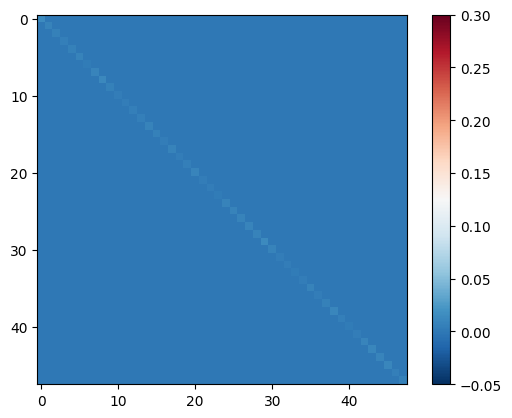

In [70]:
eig_conv_matrix=torch.cov((eig_list_arr).T)
#plt.imshow(eig_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdYlBu_r")
plt.imshow(eig_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()
eig_diag=torch.diag(eig_conv_matrix)

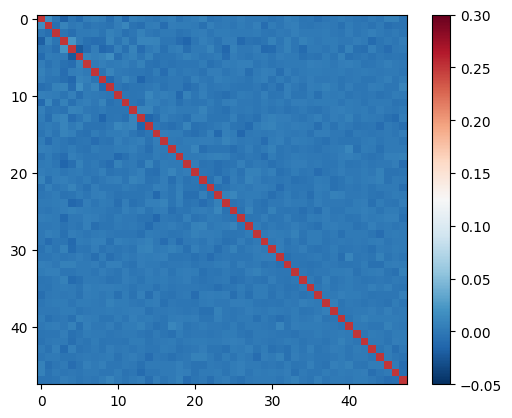

In [71]:
eig_conv_matrix=torch.cov((round_eig_list_arr).T)
#plt.imshow(eig_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdYlBu_r")
plt.imshow(eig_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()

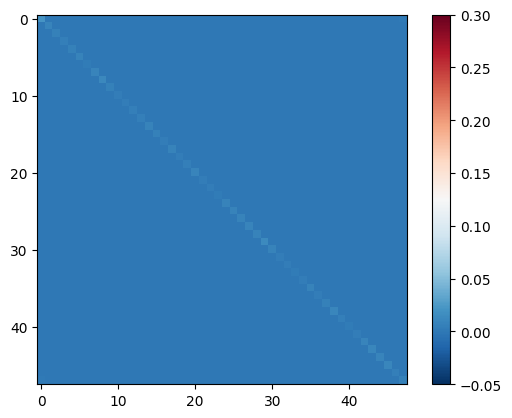

In [72]:
eigh_conv_matrix=torch.cov((eigh_list_arr).T)
plt.imshow(eigh_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()

eigh_diag=torch.diag(eigh_conv_matrix)

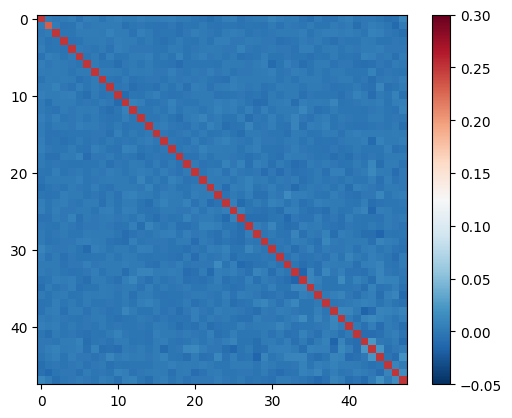

In [73]:
eigh_conv_matrix=torch.cov((round_eigh_list_arr).T)
plt.imshow(eigh_conv_matrix,vmin=-0.05,vmax=0.3,cmap="RdBu_r")
plt.colorbar()

plt.show()

In [74]:



print(eig_diag/ori_diag)
print(eigh_diag/ori_diag)

tensor([0.9998, 1.0004, 1.0000, 1.0001, 0.9998, 0.9999, 1.0000, 1.0001, 1.0000,
        1.0000, 1.0001, 0.9999, 0.9999, 0.9999, 0.9999, 1.0001, 1.0001, 1.0000,
        1.0000, 1.0000, 0.9998, 0.9992, 1.0001, 0.9999, 0.9999, 0.9999, 0.9999,
        1.0001, 1.0000, 0.9997, 1.0002, 1.0001, 1.0001, 1.0002, 0.9998, 1.0001,
        1.0001, 1.0002, 1.0000, 1.0002, 1.0000, 1.0000, 1.0000, 0.9999, 1.0001,
        1.0000, 0.9999, 1.0004])
tensor([1.3750, 1.0393, 1.0003, 1.0002, 1.0000, 1.0000, 1.0001, 1.0004, 0.9999,
        1.0000, 1.0001, 0.9999, 0.9999, 1.0004, 0.9999, 1.0001, 0.9998, 1.0000,
        0.9998, 1.0002, 1.0001, 1.0000, 1.0000, 1.0001, 1.0001, 0.9999, 1.0005,
        0.9999, 1.0003, 1.0001, 0.9999, 1.0000, 1.0000, 1.0007, 1.0009, 1.0002,
        1.0015, 1.0021, 1.0000, 1.0014, 1.0004, 1.0024, 1.0002, 1.0003, 1.0011,
        0.9999, 1.0015, 0.9999])


In [75]:
print(eig_diag)

tensor([0.0154, 0.0088, 0.0066, 0.0057, 0.0068, 0.0078, 0.0025, 0.0090, 0.0124,
        0.0062, 0.0045, 0.0041, 0.0055, 0.0058, 0.0083, 0.0069, 0.0041, 0.0077,
        0.0046, 0.0051, 0.0098, 0.0040, 0.0038, 0.0029, 0.0079, 0.0080, 0.0079,
        0.0091, 0.0079, 0.0130, 0.0080, 0.0042, 0.0036, 0.0027, 0.0042, 0.0087,
        0.0044, 0.0069, 0.0115, 0.0052, 0.0031, 0.0034, 0.0099, 0.0109, 0.0093,
        0.0103, 0.0056, 0.0061])


In [76]:
torch.save(eig_whitening_layer,'../whiten_checkpoint/rw_norm_104.pt')

: 